# Creating a GHZ State

For SRP\*400 in Winter 2019-2020 at Phillips Exeter Academy, by [Evan Chandran](https://github.com/ecchandran) and [Maxwell Wang](https://github.com/maxzwang).

Creates and measures a [Greenberger–Horne–Zeilinger (GHZ)](https://en.wikipedia.org/wiki/Greenberger%E2%80%93Horne%E2%80%93Zeilinger_state) \[1\] state using [pyQuil](https://github.com/rigetti/pyquil) and the [Quantum Virtual Machine (QVM)](https://github.com/rigetti/qvm), and plots a histogram of the outcomes.

\[1\] Daniel M. Greenberger, Michael A. Horne, and Anton Zeilinger. Going beyond bell’s theorem, 2007. [arXiv:0712.0921](https://arxiv.org/abs/0712.0921) \[quant-ph\]

In [1]:
import numpy as np
from pyquil import get_qc, Program
from pyquil.api import WavefunctionSimulator
from pyquil.gates import CNOT, H, MEASURE
from pyquil.latex import display
import matplotlib.pyplot as plt

## Choose parameters

By changing `num_qubits` and `num_shots` we can change the size of the GHZ state, and the number of samples we take.

In [2]:
num_qubits = 5  # the number of qubits to create a GHZ state with
num_shots = 1000  # the number of times to run the quantum circuit

## Build the pyQuil `Program`

Puts qubit 0 into an equal superposition state using the `H` gate, and then entangles all the qubits using `CNOT` gates, and finally measures all the qubits.

In [3]:
p = Program()
ro = p.declare('ro', 'BIT', num_qubits)
p += H(0)
for i in range(num_qubits - 1):
    p += CNOT(i, i + 1)
for i in range(num_qubits):
    p += MEASURE(i, ro[i])
p.wrap_in_numshots_loop(num_shots)
print(p)

DECLARE ro BIT[5]
H 0
CNOT 0 1
CNOT 1 2
CNOT 2 3
CNOT 3 4
MEASURE 0 ro[0]
MEASURE 1 ro[1]
MEASURE 2 ro[2]
MEASURE 3 ro[3]
MEASURE 4 ro[4]



## Display the GHZ circuit

**NOTE**: Requires `pdflatex` and `convert` to be installed (can be installed on mac via `brew install mactex imagemagick`).

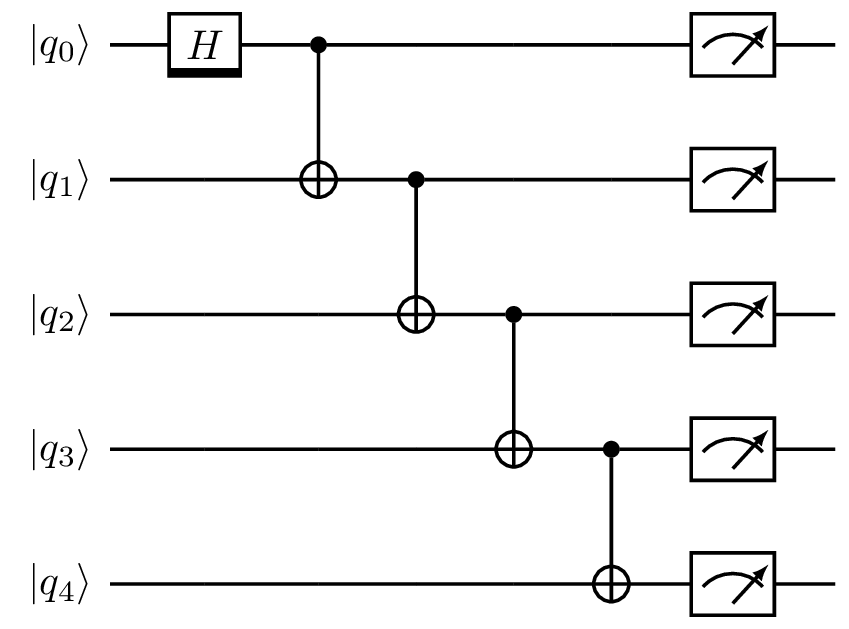

In [4]:
display(p)

## Compile and run the `Program`

By default uses a noisy QVM, meaning that we are running on a quantum simulator with simulated noise. Alternatively, if we have access to real quantum processors (QPUs) via [Quantum Cloud Services (QCS)](https://github.com/rigetti/qcs-paper) we could use actual physical qubits by replacing the string with a lattice name (e.g. `Aspen-4-3Q-D`).

In [5]:
qc = get_qc(f'{num_qubits}q-noisy-qvm')  # we've also used Aspen-4-3Q-D', 'Aspen-7-3Q-C'
executable = qc.compile(p)
result = qc.run(executable)

## Collect counts and column names

In [6]:
num_outcomes = 2 ** num_qubits  # the number of distinct bitstring outcomes
counts = [0] * num_outcomes  # a list of counts for each outcome

index = 0
for i in range(num_shots):
    for j in range(num_qubits):
        index += 2 ** (num_qubits - j - 1) * result[i][j]
    counts[index] += 1
    index = 0

names = []
for i in range(2 ** num_qubits):
    name = str(bin(i))[2:]
    while len(name) < num_qubits:
        name = '0' + name
    names.append(name)

## Plot histogram of bitstring outcomes

The wavefunction for a 5-qubit GHZ state is $|\psi\rangle = \frac{1}{\sqrt{2}} ( |00000\rangle + |11111\rangle )$, so we expect the majority of the outcomes to be `00000` and `11111`, but we observe others due to noise.

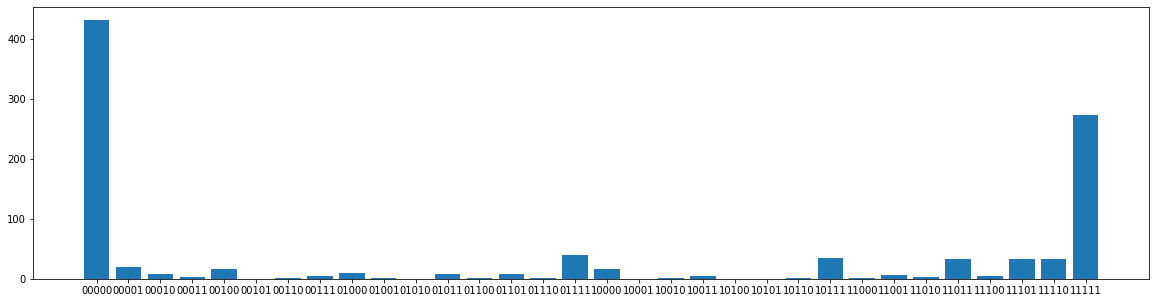

In [7]:
plt.figure(figsize=(20, 5))
plt.bar(names, counts)
if num_qubits > 5:
    plt.gca().axes.get_xaxis().set_visible(False)
plt.show()